From sky to Time-Ordered Data (and back)
====

This notebook describes how to generate timestreams from a scan of the sky.

In [1]:
## Import basic modules and routines
from __future__ import division, absolute_import, print_function

## In case you did not install properly the library 
## or didn't update your bashrc. (Do it later!)
import os
path_to_s4cmb = '../../s4cmb'
os.sys.path.insert(0, os.path.realpath(path_to_s4cmb))

import numpy as np
import pylab as pl
import healpy as hp

try:
    from tqdm import *
except ImportError:
    tqdm = lambda x: x

First, let's create a simple instrument following the instrument notebook

In [2]:
from s4cmb.instrument import Hardware

inst = Hardware(ncrate=4, ndfmux_per_crate=1,
                nsquid_per_mux=1, npair_per_squid=16,
                fp_size=60., fwhm=3.5, 
                beam_seed=58347, projected_fp_size=3., pm_name='5params',
                type_hwp='CRHWP', freq_hwp=2., angle_hwp=0., verbose=False)

Then, we need to define a scanning strategy. Again, following the scanning strategy notebook we use the ScanningStrategy class. For this example, we generate only one scan (one CES) of 4 hours:

In [3]:
from s4cmb.scanning_strategy import ScanningStrategy

scan = ScanningStrategy(nces=1, start_date='2013/1/1 00:00:00',
                        telescope_longitude='-67:46.816',
                        telescope_latitude='-22:56.396', telescope_elevation=5200.,
                        name_strategy='deep_patch', sampling_freq=8., sky_speed=0.4,
                        ut1utc_fn='../../s4cmb/s4cmb/data/ut1utc.ephem',
                        language='fortran', verbose=False)
scan.run()

Note that unlike the scanning strategy notebook, we use language=fortran to benefit from a massive speed-up. Finally, one needs to simulate a CMB sky to be scanned. The necessary tools are found in the module input_sky.py. for test purposes, we create the (Gaussian) maps on-the-fly from a CAMB file, but in real-life run you may want to read your own file (properly lensed for example). Note that HealpixFitsMap can take as inputs either CAMB file, or fits file containing either maps or alms. 

In [4]:
from s4cmb.input_sky import HealpixFitsMap

nside_out = 512
path_to_cls = '../../s4cmb/s4cmb/data/test_data_set_lensedCls.dat'
sky_in = HealpixFitsMap(path_to_cls, do_pol=True, fwhm_in=inst.beam_model.fwhm,
                        nside_in=nside_out, map_seed=5843787, 
                        verbose=False, no_ileak=False, no_quleak=False)

Note that you need to specify the resolution of the map based on your instrument. The arguments no_ileak and no_quleak are used to disable T (no_ileak=True) or QU (no_quleak=True) fields while scanning. This is particularly useful if you want to study only T -> T leakage or T -> P leakage or P -> P leakage separately. Here we set all to False, namely we want to make TOD with all fields.

Let's now generate our TOD from our input sky, instrument, and scanning strategy. Since we have only one scan in this example, we have:

In [5]:
from s4cmb.tod import TimeOrderedDataPairDiff

tod = TimeOrderedDataPairDiff(
    inst, scan, sky_in, 
    CESnumber=0, 
    projection='healpix', 
    pixel_size=None, nside_out=nside_out, 
    array_noise_level=None, array_noise_seed=None,
    width=130., mapping_perpair=False)
        
## Scan input map to get TODs
d = np.array([
        tod.map2tod(det) for det in tqdm(
            range(inst.focal_plane.nbolometer))])

100%|██████████| 128/128 [00:08<00:00, 15.01it/s]


Let's explain what happened. 

First if we had more scans, we would just loop over the number of scans defined in our scanning strategy. Moreover scans are independent and so you can trivially parallelised the loop with many processors (or group of).

Second, we create an instance of TimeOrderedDataPairDiff by feeding our instrument, our scanning strategy and our input sky maps. In addition, we ask the output map to use the healpix projection (projection='healpix'). Note that one can also project TOD into flat maps (projection='flat', use the cylindrical equal area projection). The projection of the output map is independent of the projection used for the input map (generally these can be two different operators). Note that if you use projection='flat', you need to specify the size of pixels for the output map (in arcmin). We set it to None here as we are using healpix.

Third, you can inject instrument noise in TOD while scanning the sky. Only white noise is available for the moment. We will see later how this works.

Fourth, you need to specify the width on sky for the output map (in degree). Why so since we already have a scanning strategy with defined boundaries? Because sometimes you want 1) to save memory by storing only a part of the entire scanned map or 2) sometimes you want to pad you map by adding zeros around the scanned area. I reckon this is not ideal, but trust me this is useful. Long story short: make sure that (width, ra_src, dec_src) returns a sky patch bigger than what has been defined in the scanning strategy, or you will have truncated output sky maps.

Fifth, mapping_perpair... By default the code expects that you want to perform the time to map domain operations at once, that is projecting all detectors at the same time. This is indeed great, but can be extremely memory consuming if you have thousands of TOD to store! So mapping_perpair=True allows you to map detectors one-by-one, hence loading very few objects on the memory at the same time. Note that the structure of the App changes a bit if you select mapping_perpair=True, as we will see later. Of course, mapping_perpair=True implies that your detector's TOD are uncorrelated. This might not be always the case when studying instrument systematics, and you might be forced to use mapping_perpair=False anyway (so be ready to have access to machine with enough memory).

Finally, map2tod! If you are familiar with healpix, this is in the same vein as map2alm, alm2cl, etc. This routine lets you go from one domain (map) to another (time). More specifically it scans the input sky maps to generate timestream for detector det. Note that this is currently the bottleneck in computation. Need to speed-up this routine! Hopefully everything is linear ;-)

OK, let's have a look at those TOD! Here, a TOD means d(t) = I(t) + Q(t)cos(2theta(t)) + U(t)sin(2theta(t)), where I, Q, and U are the input Stokes maps, and theta is the polarisation angle made of the parallactic angle, (twice the) HWP angle and intrinsic polarisation angle.

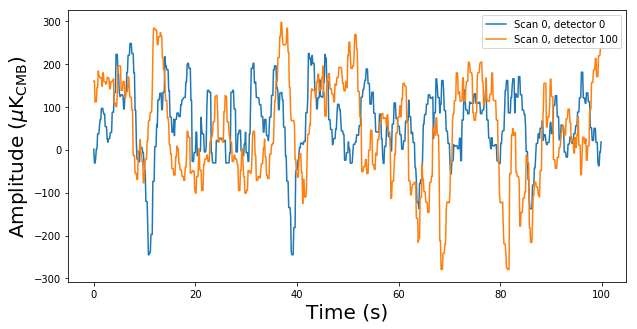

In [6]:
stop = 800
xaxis = [t/scan.sampling_freq for t in range(0, stop)]

fig = pl.figure(figsize=(10, 5))

pl.plot(xaxis, d[0][0:stop], label='Scan 0, detector 0')
pl.plot(xaxis, d[100][0:stop], label='Scan 0, detector 100')

pl.xlabel('Time (s)', fontsize=20)
pl.ylabel('Amplitude ($\mu$K$_{\\rm CMB}$)', fontsize=20)
pl.legend()
pl.show()

Let's now project back our data into a sky map. We will use the difference of pairs of detectors to reconstruct the polarisation (no demodulation yet in s4cmb). Guess what? Previously we went from map to time domain using map2tod, now we will go from time to map domain using tod2map! Again, for our single scan that means

In [7]:
from s4cmb.tod import OutputSkyMap

## Initialise output map container
sky_out_tot = OutputSkyMap(projection=tod.projection,
                           nside=tod.nside_out,
                           obspix=tod.obspix,
                           npixsky=tod.npixsky,
                           pixel_size=tod.pixel_size)

tod.tod2map(d, sky_out_tot)

In the absence of systematics, these operations should not change the signal (that is map1 -> tod -> map2 implies map2 = map1). Let's check that we did not harm the signal:

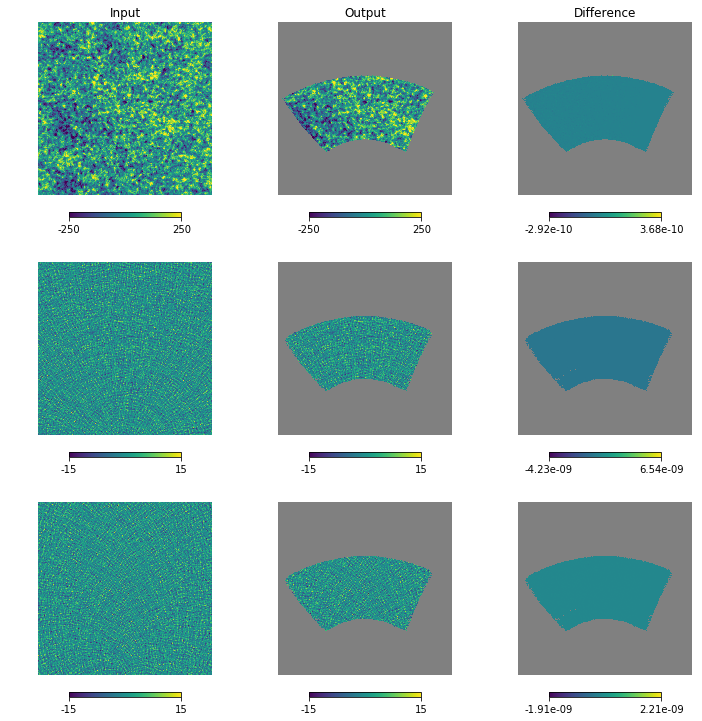

In [9]:
from s4cmb.tod import partial2full

xsize = 550
fig = pl.figure(figsize=(10, 10))

nhit = partial2full(sky_out_tot.nhit, sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)

## Temperature
sky_out = partial2full(sky_out_tot.get_I(), sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)

mask = nhit < 1
sky_out[mask] = np.nan
hp.gnomview(sky_in.I, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=331, 
            title='Input', notext=True, min=-250, max=250)
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=332, 
            title='Output', notext=True, min=-250, max=250)
hp.gnomview(sky_in.I - sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=333, 
            title='Difference', notext=True)

## Stokes Q
sky_out = partial2full(sky_out_tot.get_QU()[0], sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)
mask = nhit < 10
sky_out[mask] = np.nan

hp.gnomview(sky_in.Q, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=334, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=335,  
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_in.Q - sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=336, 
            notext=True, title='')

## Stokes U
sky_out = partial2full(sky_out_tot.get_QU()[1], sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)
mask = nhit < 10
sky_out[mask] = np.nan
hp.gnomview(sky_in.U, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=337, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=338, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_in.U - sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=339, 
            notext=True, title='')
pl.show()

The difference is indeed negligible!